In [1]:
import os
import logging
import sys
import contexttimer

import numpy as np
if os.path.basename(os.getcwd()) != 'runlmc':
    os.chdir('..')
sys.path.append('benchmarks/benchlib')
from standard_tester import foreign_exchange_2007, smse, nlpd, cogp_fx2007

from runlmc.models.lmc import LMC, _LOG
from runlmc.kern.rbf import RBF
from runlmc.models.optimization import AdaDelta
from runlmc.models.gpy_lmc import GPyLMC

%matplotlib inline 
import matplotlib.pyplot as plt

logging.getLogger().addHandler(logging.StreamHandler())
_LOG.setLevel(logging.INFO)

In [2]:
# Nguyen 2014 COGP uses Q=2 R=1, but that is not LMC
# Álvarez and Lawrence 2010 Convolved GP has R=4, sort of.
# Álvarez and Lawrence 2010 find that vanilla LMC works best with Q=1 R=2
# that is what we use here
ks = [RBF(name='rbf0')]
ranks = [2]
# the columns with nonzero test holdout are in test_fx
xss, yss, test_xss, test_yss, test_fx, cols = foreign_exchange_2007()

In [5]:
np.random.seed(1234)
lmc = LMC(xss, yss, kernels=ks, ranks=ranks)
opt = AdaDelta(verbosity=20, min_grad_ratio=0.1)
with contexttimer.Timer() as t:
    lmc.optimize(optimizer=opt)
pred_yss, pred_vss = lmc.predict(test_xss)
llgp_time = t.elapsed
llgp_smse = smse(test_yss, pred_yss, yss)
llgp_nlpd = nlpd(test_yss, pred_yss, pred_vss)
print('time', llgp_time, 'smse', llgp_smse, 'nlpd', llgp_nlpd)

LMC lmc generating inducing grid n = 3054
LMC lmc grid (n = 3054, m = 238) complete, 
LMC lmc fully initialized
Optimization (53 hyperparams) starting with 4 workers


starting adadelta {'min_grad_ratio': 0.1, 'permitted_drops': 5, 'roll': 1, 'callback': <function AdaDelta.noop at 0x7f5fd6a3c598>, 'max_it': 100, 'decay': 0.9, 'verbosity': 20, 'momentum': 0.5, 'offset': 0.0001, 'step_rate': 1}
iteration        5 grad norm 9.4451e+01
iteration       10 grad norm 8.9239e+01
iteration       15 grad norm 7.9765e+01
iteration       20 grad norm 1.5533e+02
iteration       25 grad norm 2.9259e+02
iteration       30 grad norm 8.3530e+01
iteration       35 grad norm 2.8350e+02
iteration       40 grad norm 1.4872e+02
iteration       45 grad norm 4.4359e+02
iteration       50 grad norm 2.1527e+02
iteration       55 grad norm 6.0931e+02
iteration       60 grad norm 9.5157e+02
iteration       65 grad norm 1.4468e+02
iteration       70 grad norm 2.0552e+02
iteration       75 grad norm 9.4648e+01
iteration       80 grad norm 3.2328e+02
iteration       85 grad norm 3.2205e+02
iteration       90 grad norm 2.9350e+02


MINRES (n = 3054) did not converge in n iterations. Reconstruction error 8.912475e-05
MINRES (n = 3054) did not converge in n iterations. Reconstruction error 8.855279e-05


iteration       95 grad norm 2.4976e+02


MINRES (n = 3054) did not converge in n iterations. Reconstruction error 1.056151e-04
MINRES (n = 3054) did not converge in n iterations. Reconstruction error 1.019499e-04
MINRES (n = 3054) did not converge in n iterations. Reconstruction error 1.118653e-04
MINRES (n = 3054) did not converge in n iterations. Reconstruction error 1.094955e-04
MINRES (n = 3054) did not converge in n iterations. Reconstruction error 2.372169e-04
MINRES (n = 3054) did not converge in n iterations. Reconstruction error 2.468631e-04
MINRES (n = 3054) did not converge in n iterations. Reconstruction error 2.435773e-04
MINRES (n = 3054) did not converge in n iterations. Reconstruction error 2.256469e-04
MINRES (n = 3054) did not converge in n iterations. Reconstruction error 2.788246e-04
MINRES (n = 3054) did not converge in n iterations. Reconstruction error 3.372610e-04
MINRES (n = 3054) did not converge in n iterations. Reconstruction error 3.013748e-04
MINRES (n = 3054) did not converge in n iterations. Re

iteration      100 grad norm 7.9252e+02
finished adadelta optimization
           100 iterations
    7.9252e+02 final grad norm
    7.9252e+02 final MA(1) grad norm
    9.5157e+02 max MA(1) grad norm
    norm used inf


MINRES (n = 3054) did not converge in n iterations. Reconstruction error 1.518434e-04
MINRES (n = 3054) did not converge in n iterations. Reconstruction error 1.302565e-03
MINRES (n = 3054) did not converge in n iterations. Reconstruction error 1.236833e-03
MINRES (n = 3054) did not converge in n iterations. Reconstruction error 1.374766e-03
MINRES (n = 3054) did not converge in n iterations. Reconstruction error 1.278114e-03
Using 4 processors for 150 on-the-fly variance predictions


time 318.86925358098233 smse 0.34245259108 nlpd -3.3583817986


In [4]:
# 1 run only, 100 inducing points, as in the paper
cogp_time, cogp_smse, cogp_nlpd, cogp_mu, cogp_var = cogp_fx2007(1, 100)
print('time', cogp_time, 'smse', cogp_smse, 'nlpd', cogp_nlpd)

time 298.10209 smse 0.277124059474196 nlpd 13.029685027721913


In [5]:
all_xs = np.arange(min(xs.min() for xs in xss), max(xs.max() for xs in xss) + 1)
test_ix = {col: list(cols).index(col) for col in test_fx}
pred_xss = [all_xs if col in test_fx else np.array([]) for col in cols]
lmc.prediction = 'exact'
pred_yss, pred_vss = lmc.predict(pred_xss)
pred_yss = {col: ys for col, ys in zip(cols, pred_yss)}
pred_vss = {col: vs for col, vs in zip(cols, pred_vss)}

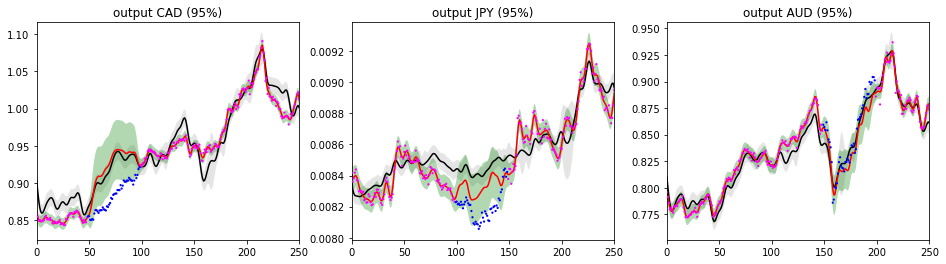

In [6]:
_, axs = plt.subplots(ncols=3, figsize=(16, 4))
for col, ax in zip(test_fx, axs):
    
    # Prediction on entire domain for COGP
    ax.plot(all_xs, cogp_mu[col], c='black', ls='-')
    sd = np.sqrt(cogp_var[col])
    top = cogp_mu[col] + 2 * sd
    bot = cogp_mu[col] - 2 * sd
    ax.fill_between(all_xs, bot, top, facecolor='grey', alpha=0.2)
    
    # Prediction for LLGP
    ax.plot(all_xs, pred_yss[col], c='red')
    sd = np.sqrt(pred_vss[col])
    top = pred_yss[col] + 2 * sd
    bot = pred_yss[col] - 2 * sd
    ax.fill_between(all_xs, bot, top, facecolor='green', alpha=0.3)    
    
    # Actual holdout
    marker_size = 5
    test_xs = test_xss[test_ix[col]]
    test_ys = test_yss[test_ix[col]]
    ax.scatter(test_xs, test_ys, c='blue', edgecolors='none', s=marker_size, zorder=11)
    
    # Rest of image (training)
    rest_xs = xss[test_ix[col]]
    rest_ys = yss[test_ix[col]]
    ax.scatter(rest_xs, rest_ys, c='magenta', edgecolors='none', s=marker_size, zorder=10)
        
    ax.set_xlim([0, 250])
    ax.set_title('output {} (95%)'.format(col))

plt.savefig('fx2007graph.pdf', format='pdf', bbox_inches='tight')
plt.show()

In [7]:
sum(map(len, xss)), sum(map(len, test_xss))

(3054, 150)

In [8]:
# warning: precompute takes a while, ~10 min on a 4-core 2015 laptop
methods = ['on-the-fly', 'exact', 'precompute']
results = []
for m in methods:
    lmc.prediction = m
    with contexttimer.Timer() as t:
        pred_yss, pred_vss = lmc.predict(test_xss)
    print('method {: <12} smse {:6.4f} nlpd {:13.4e} time {}'.format(
            m, 
            smse(test_yss, pred_yss, yss),
            nlpd(test_yss, pred_yss, pred_vss),
            t.elapsed))
    results.append(np.hstack(pred_vss))

Using 80 processors for 150 on-the-fly variance predictions


method on-the-fly   smse 0.2164 nlpd   -3.4756e+00 time 4.602091901004314


Using 80 processors to precompute 3094 variance terms exactly


method exact        smse 0.2164 nlpd   -3.4929e+00 time 0.321654811501503
method precompute   smse 0.2164 nlpd   -3.4928e+00 time 56.45702739804983


In [9]:
onthefly, exact, precomp = results
def rel_norm_diff(exact, x):
    diff = np.linalg.norm(exact - x)
    orig = np.linalg.norm(exact)
    return diff / orig
print('on the fly ', rel_norm_diff(exact, onthefly))
print('precomputed', rel_norm_diff(exact, precomp))

on the fly  0.0121914613227
precomputed 0.000483875919532


In [10]:
n = len(lmc.y)
m = len(lmc.inducing_grid)
D = len(lmc.noise)
Q = len(lmc.kernels)
R = int(sum(ranks) / Q)
paramstr = 'n={},m={},D={},Q={},R={}'.format(n, m, D, Q, R)
paramstr

'n=3054,m=238,D=13,Q=1,R=2'

In [11]:
# warning: last one takes ~10 min on a 4-core 2015 laptop
samples = [100, 500, 1000]
samp_results = []
for s in samples:
    lmc.prediction = 'sample'
    lmc.variance_samples = s
    if 'sampled_nu' in lmc._cache:
        del lmc._cache['sampled_nu']
    with contexttimer.Timer() as t:
        pred_yss, pred_vss = lmc.predict(test_xss)
    print('method {: <12} smse {:6.4f} nlpd {:13.4e} time {}'.format(
            'sample {:5d}'.format(s), 
            smse(test_yss, pred_yss, yss),
            nlpd(test_yss, pred_yss, pred_vss),
            t.elapsed))
    samp_results.append(np.hstack(pred_vss))

Using 80 processors to precompute 1 kernel factors
encountered incomplete rank 214 of 238 order kernel 0
Using 80 processors to precompute 100 variance samples
Using 80 processors to precompute 1 kernel factors


method sample   100 smse 0.2164 nlpd   -3.4623e+00 time 8.048227593302727


encountered incomplete rank 214 of 238 order kernel 0
Using 80 processors to precompute 500 variance samples


method sample   500 smse 0.2164 nlpd    6.3511e+00 time 30.713683903217316


Using 80 processors to precompute 1 kernel factors
encountered incomplete rank 214 of 238 order kernel 0
Using 80 processors to precompute 1000 variance samples


method sample  1000 smse 0.2164 nlpd   -2.6242e+00 time 61.84645803272724


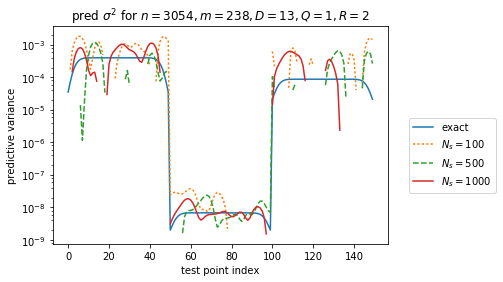

In [12]:
plt.semilogy(exact, label='exact')
lss = [':', '--', '-']
for ns, res, ls in zip(samples, samp_results, lss):
    plt.semilogy(res, label=r'$N_s={}$'.format(ns), ls=ls)
plt.title(r'pred $\sigma^2$ for ${}$'.format(paramstr))
plt.xlabel('test point index')
plt.ylabel('predictive variance')
plt.legend(bbox_to_anchor=(1.05, 0.6), loc=2)
plt.show()

In [ ]:
# also takes ~10 min
np.random.seed(1234)
lmc_with_metrics = LMC(xss, yss, kernels=ks, ranks=ranks, metrics=True)
lmc_with_metrics.optimize(optimizer=AdaDelta(
        # Force full 35 iterations with ratio = 0
        verbosity=10, max_it=35, min_grad_ratio=0))

In [ ]:
def moving_average(a, n) :
    sums = np.add.accumulate(a, dtype=float)
    sums[n:] = sums[n:] - sums[:-n]
    sums[n:] /= n
    sums[:n] /= np.arange(1, n + 1)
    return sums

def div_rolled_max(a, n):
    ma = moving_average(a, n)
    roll_max = np.maximum.accumulate(ma)
    return roll_max

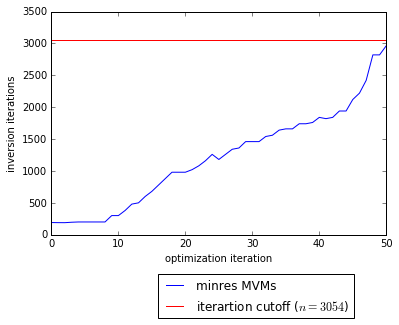

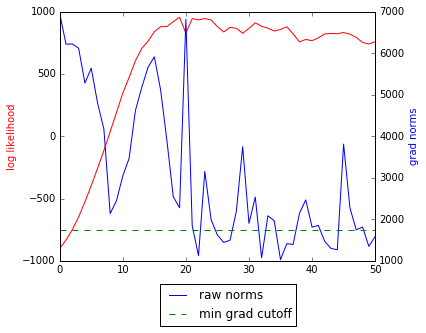

In [12]:
plt.plot(lmc_with_metrics.metrics.iterations, label='minres MVMs')
n = len(lmc_with_metrics.y)
plt.axhline(n, label='iterartion cutoff ($n={}$)'.format(n), c='r')
plt.xlabel('optimization iteration')
plt.ylabel('inversion iterations')
plt.legend(bbox_to_anchor=(.3, -0.15), loc=2)
plt.savefig('iterations.eps', format='eps', bbox_inches='tight')
plt.show()

fig, ax1 = plt.subplots()
ax1.plot(lmc_with_metrics.metrics.log_likely, c='r')
ax1.set_ylabel('log likelihood', color='r')
ax2 = ax1.twinx()
ax2.plot(lmc_with_metrics.metrics.grad_norms, c='b', label='raw norms')

# Roll = 1 by default
    ax2.plot(0.2 * div_rolled_max(lmc_with_metrics.metrics.grad_norms, 1), c='g', ls='--', 
         label='min grad cutoff')
ax2.set_ylabel('grad norms', color='b')
fig.tight_layout()
plt.legend(bbox_to_anchor=(.3, -.07), loc=2)
plt.savefig('running_cutoff.eps', format='eps', bbox_inches='tight')
plt.show()